Submission for <br>
Exercise task 3 <br>
of UTU course TKO_8964-3006 <br>
Textual Data Analysis <br>
by Botond Ortutay <br>

---

**Instructions:**

# Translation mining

In this exercise you will test comparing two texts:
  1. The Finnish translation of the Adventures of Huckleberry Finn (the whole book)
  2. A small section of the English original

In the exercise you should convince yourself that the cross-lingual embedding models can indeed identify the area where the texts match. You can do so by splitting the texts into small overlapping segments, embedding each using a cross-lingual model, comparing the embeddings all against all with cosine similarity, and plotting the results as a heatmap. When splitting the texts, a 2000-character long sliding window with stride of 500 characters worked for me, so you can use that as a reasonable default. The result should look something like the image below. You can clearly see the line where the English text matches the Finnish text. Your job is to replicate this result. :)

For this to work, I suggest you use the model named `paraphrase-xlm-r-multilingual-v1` in the Sentence Transformer library. Most likely you will want to use GPU, but do protect your Colab quota and debug your code on a small sample using CPU while developing, and only switch to GPU when ready to run the whole thing.

The English text: https://www.gutenberg.org/ebooks/7104.txt.utf-8

The Finnish text: https://www.gutenberg.org/ebooks/47095.txt.utf-8

The result should end up looking something like this (give or take colors, ranges, etc which might differ for you. You recognize a correct solution by a clear, long line.

---

**Solution:**

**Importing libraries & environment setup:** <br>
Here we of course assume that whomever runs this notebook has all the required libraries downloaded AND accesses a GPU to run Sentence Transformer on. We also assume that whomever runs this notebook has his/her Jupyter configured in such a way that they can run Bash commands

In [1]:
# imports
import sentence_transformers
import torch
import matplotlib.pyplot as plt

# checking GPU availability
print(torch.cuda.is_available()) # should output True

True


**Defining & documenting functions used below:**

In [2]:
"""
A function that reads in a file and returns the file contents in a list, sliced in a sliding window fashion, with custom window length and stride
---
In:
path                  str                    name of the file to be read in. NOTE: assumes such a file exists in the same directory where this notebook is.
winLength             int                    length of the sliding window
stride                int                    Answers the question: How much should the sliding window move per iteration?
---
Out
slidingWindowSplit    list (contains str)    Contains the input file sliced in a sliding window fashion
"""
def f2splitTxtWSlidingWindow(path,winLength,stride):
    # Opening file, extracting content, setting up variables
    f = open(path, "r")
    fContents = f.read()
    FILE_LENGTH = len(fContents)
    slidingWindowSplit = []

    # Generating list with file contents spliced by sliding window
    for i in range(0, FILE_LENGTH, stride):
        if i+winLength >= FILE_LENGTH:
            slidingWindowSplit.append(fContents[i:FILE_LENGTH])
        else:
            slidingWindowSplit.append(fContents[i:i+winLength])

    # Closing file, returning generated split
    f.close()
    return slidingWindowSplit

**Downloading resources:**

In [3]:
#NOTE: Bash commands here, make sure your Jupyter configuration lets you run them!
!wget https://www.gutenberg.org/ebooks/7104.txt.utf-8
!wget https://www.gutenberg.org/ebooks/47095.txt.utf-8
!mv 7104.txt.utf-8 short_en_data.txt.utf-8
!mv 47095.txt.utf-8 fin_data.txt.utf-8
!echo
!echo
!ls



7[Files: 0  Bytes: 0  [0 B/s] Re]87[https://www.gutenberg.org/eboo]877104.txt.utf-8       100% [=============================>]     302     --.-KB/s87HTTP response 302  [https://www.gutenberg.org/ebooks/7104.txt.utf-8]
877104.txt.utf-8       100% [=============================>]     302     --.-KB/s87Adding URL: http://www.gutenberg.org/cache/epub/7104/pg7104.txt
87[Files: 0  Bytes: 302  [318 B/s]87[Files: 0  Bytes: 302  [302 B/s]87[http://www.gutenberg.org/cache]877104.txt.utf-8         0% [<=>                           ]       0     --.-KB/s87HTTP response 302 Found [http://www.gutenberg.org/cache/epub/7104/pg7104.txt]
877104.txt.utf-8         0% [ <=>                          ]       0     --.-KB/s87Adding URL: https://www.gutenberg.org/cache/epub/7104/pg7104.txt
87[Files: 0  Bytes: 302  [251 B/s]87[https://www.gutenberg.org/cach]87Saving '7104.txt.utf-8'
877104.txt.utf-8       100% [=============================>]   88.09K    --.-KB/s87HTTP resp

**Model setup and embeddings:**

In [4]:
# Download model and configure to run on GPU and calculate cosine similarity
model = sentence_transformers.SentenceTransformer(model_name_or_path="sentence-transformers/paraphrase-xlm-r-multilingual-v1", device="cuda", similarity_fn_name="cosine")

In [5]:
# Load in data for processing
sEnData = f2splitTxtWSlidingWindow("short_en_data.txt.utf-8",2000,500)
finData = f2splitTxtWSlidingWindow("fin_data.txt.utf-8",2000,500)

In [6]:
# Calculating embeddings
sEnEmbeddings = model.encode(sEnData)
finEmbeddings = model.encode(finData)

In [7]:
# Calculating embedding similarity
similarities = model.similarity(sEnEmbeddings, finEmbeddings)

**Visualization:**

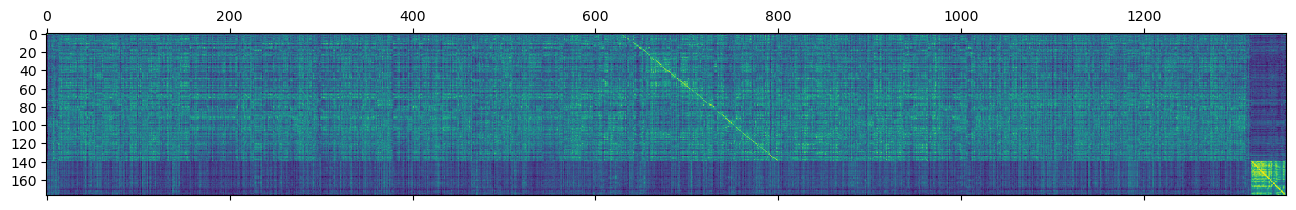

In [8]:
plt.matshow(similarities)
plt.show()

**The takeaways:** <br>
In this exercise I have the requested resources, read them in & reformatted them using a custom function, set up a sentence transformer (to run on my GPU with the recommended model) and ran the books through it to calculate embeddings, performed similarity analysis on them and then visualized the result.

**What does the output mean?** <br>
My interpretation is the following: if we take a look at the shape of the data

In [9]:
print(sEnEmbeddings.shape)
print(finEmbeddings.shape)

(177, 768)
(1356, 768)


We can see that both of their y-size is 768. The fact that the y-sizes match, means that the x-size corresponds to all the windows created from the original book data. So then the y-sizes are the embeddings generated by the model. So the model generates 768 embeddings for each window. When performing similarity analysis, we check how many of these generated embeddings match (or are close enough). The bright line that starts at around (650,0) and ends at around (800,140) means that subsequent windows from each of the target materials have a high similarity score. In other words: that part is a direct translation.